In [1]:
import unittest
from mrftools import *
import numpy as np
from scipy.stats import bernoulli
#import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
np.random.seed(0)


In [2]:
"""
Created on Wed May 15 11:54:57 2019
@author: daryl

#######################################################################
# BASED On An Original Sage Version by:
# AUTHOR: Dr. Christian Schridde
# E-MAIL: christianschridde [at] googlemail [dot] com
#
# DESCRIPTION: Implementation of the FKT-algorithm
#
# INPUT:  Adjacency matrix A of a undirected loop-free planar graph G
# OUTPUT: The number of perfect matchings of G
########################################################################
"""

import networkx as nx #Requires at least netwrokx 2.3+
import matplotlib.pyplot as plt
import random
import math
import numpy as np
import time

#Helper Functions
def doNothing():
    return 0;

def find_faces(embd):
    

    #Returns a list of faces of the planar embedding by 
    #the edges that bound the face
    ed_list = list(embd.edges())
    faces=[]
    
    for ed in embd.edges():
        if ed in ed_list:
            faces.append(embd.traverse_face(ed[0],ed[1]))
            
            for i in range(len(faces[-1])):
                ed_list.remove((faces[-1][i],faces[-1][(i+1)%len(faces[-1])]))
                
    face_edges=[]
    for face in faces:
        face_edges.append([])
        for i in range(len(face)):
            face_edges[-1].append((face[i],face[(i+1)%len(face)]))
            
                
    return face_edges


def toSkewSymmetricMatrix(A):
    #Skew--symmetrize a matrix
     
    A[(A==1).T] = -1

    return A

def numberOfClockwiseEdges(face, edgesT1):

    #Iterate over edges of a face to determine
    #the number of positive orientations

    clockwise = 0
    for edge in face:
        try:
            edgesT1.index(edge)
        except ValueError:
            doNothing()
        else:
            clockwise += 1
    return clockwise


def isClockwise(e,face):
    #Checks orientation of an edge on a face
    try:
        face.index(e);
    except ValueError:
        return False
    else:
        return True

#Main Function
def FKT(A):
    n = len(A)
    B_graph = A[:]

    G = nx.Graph(A)

    tf, embd = nx.check_planarity(G)
    
    if embd is None:
        return 0

    faces = find_faces(embd)

    T1 = nx.minimum_spanning_tree(G)
    T1 = nx.Graph(T1)

    mask = np.random.randint(2, size=(n, n))
    mask = ((mask + mask.T) == 1)

    B_digraph = A * mask

    G = nx.DiGraph(B_digraph)

    edgesT1 = T1.edges();
    adj_T1 = (nx.adjacency_matrix(T1)).todense();

    for edge in edgesT1:
        if (B_digraph[edge[0], edge[1]] == 0):
            adj_T1[edge[0], edge[1]] = 0
        else:
            adj_T1[edge[1], edge[0]] = 0

    T1 = nx.DiGraph(adj_T1)
    edgesT1 = list(T1.edges())
    if embd is not None:
        faces.sort(key=len)
        faces.reverse()
        faces.pop(0)
        
    if embd is not None:
        while (len(faces) > 0):
            index = -1;
            for face in faces:
                countMissingEdges = 0;
                missingEdge = 0;
                index += 1;
                for edge in face:
                    try:
                        idx1 = edgesT1.index(edge);
                    except ValueError:
                        try:
                            idx2 = edgesT1.index((edge[1], edge[0]));
                        except ValueError:
                            countMissingEdges += 1;
                            missingEdge = edge;
                        else:
                            doNothing();
                    else:
                        doNothing();

                if (countMissingEdges == 1):
                # in this face, only one edge is missing.
                # Place the missing edge such that the total number
                # of clockwise edges of this face is odd
                # add this edge to the spanning tree
                    if ((numberOfClockwiseEdges(face, edgesT1)) % 2 == 1):
                    # insert counterclockwise in adj_T1;
                        if (isClockwise(missingEdge, face) == False):
                            adj_T1[missingEdge[0], missingEdge[1]] = 1;
                        else:
                            adj_T1[missingEdge[1], missingEdge[0]] = 1;
                    else:
                    # insert clockwise in adj_T1
                        if (isClockwise(missingEdge, face) == True):
                            adj_T1[missingEdge[0], missingEdge[1]] = 1;
                        else:
                            adj_T1[missingEdge[1], missingEdge[0]] = 1;

                # rebuild the graph
                    T1 = nx.DiGraph(adj_T1);
                    edgesT1 = list(T1.edges());

                # remove the face that was found
                    faceFound = faces.pop(index);
                    break;
        try: 
            return math.sqrt(np.linalg.det(toSkewSymmetricMatrix(adj_T1)));
        except ValueError: 
            pass    

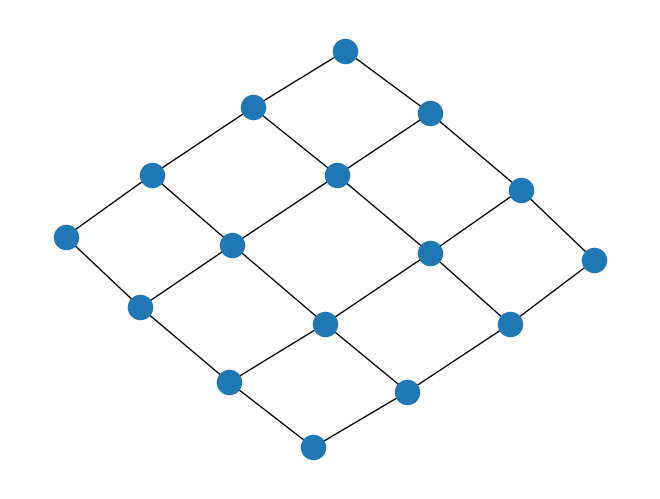

In [3]:
n = 4 # should be even
grid_size = n**2
k = 2 #alphabet size

mn = MarkovNet()
A = np.zeros([grid_size , grid_size])

for i in range(grid_size):
    mn.set_unary_factor(i, np.ones(k))
    
for i in range(grid_size):
    for j in range(grid_size):
        if  j-i ==1 and j%n !=0 :
            #print(i,j)
            #u = np.random.uniform(0, 1, 1)[0]
            u = 1
            A[i,j] = u
            mn.set_edge_factor((i, j), np.array([[ np.exp(u) , np.exp(-u)], [np.exp(-u), np.exp(u)]]) )
        if j-i == n:
            #print(i,j)
            #u = np.random.uniform(0, 1, 1)[0]
            u =1
            mn.set_edge_factor((i, j), np.array([[ np.exp(u) , np.exp(-u)], [np.exp(-u), np.exp(u)]]) )
            A[i,j] = u

#D = A + np.transpose(A)


#bf = BruteForce(mn)
#z_true = np.log(bf.compute_z())
#print("z_true:\t", z_true)
 
G = nx.Graph(A)
nx.draw(G)
plt.savefig('grid4.pdf')
#print(A)
#print(D)
#print(-np.transpose(D) == D)

In [4]:
a = FKT(A)
print(a, np.log(a))


36.0 3.58351893845611


In [5]:
edge_probabilities = dict()

for edge in mn.edge_potentials:
    #edge_probabilities[edge] = np.random.uniform(0,1,1)[0]
    #edge_probabilities[edge] = 2/grid_size # in complete graph
    edge_probabilities[edge] = (n+1)/(2*n)  # for planar graph

0.05
TRBP matrix energy functional: 77.878940
0.0975
TRBP matrix energy functional: 77.878940
0.14500000000000002
TRBP matrix energy functional: 77.878940
0.1925
TRBP matrix energy functional: 77.878940
0.24
TRBP matrix energy functional: 77.878940
0.2875
TRBP matrix energy functional: 77.878940
0.335
TRBP matrix energy functional: 77.878940
0.3825
TRBP matrix energy functional: 77.878940
0.43
TRBP matrix energy functional: 77.878940
0.4775
TRBP matrix energy functional: 77.878940
0.525
TRBP matrix energy functional: 77.878940
0.5725
TRBP matrix energy functional: 77.878940
0.6200000000000001
TRBP matrix energy functional: 77.878940
0.6675000000000001
TRBP matrix energy functional: 77.878940
0.7150000000000001
TRBP matrix energy functional: 77.878940
0.7625000000000001
TRBP matrix energy functional: 77.878940
0.81
TRBP matrix energy functional: 77.878940
0.8575
TRBP matrix energy functional: 77.878940
0.905
TRBP matrix energy functional: 77.878940
0.9525
TRBP matrix energy functional: 

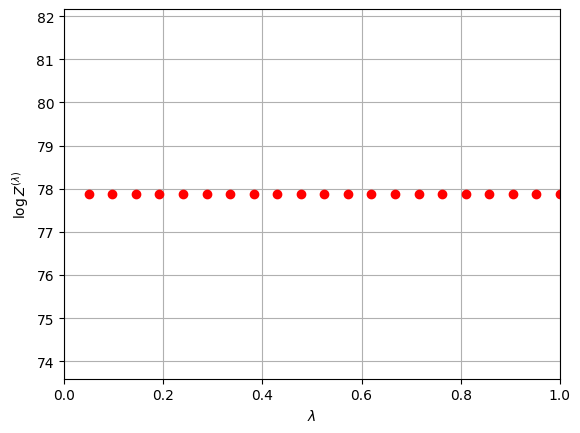

In [7]:
Z = []
tt = np.linspace(0.05, 1, 21)

for t in tt:

  for key, value in edge_probabilities.items():
      edge_probabilities[key] = value + t * (1-value)

  print(t)
  #trbp = MatrixTRBeliefPropagator(mn, edge_probabilities)
  trbp = TreeReweightedBeliefPropagator(mn, edge_probabilities)
  trbp.infer(display='off')
  trbp.load_beliefs()
  Z.append(trbp.compute_energy_functional())
  print ("TRBP matrix energy functional: %f" % trbp.compute_energy_functional())



np.savetxt("out/Z.txt", np.array(Z))


plt.figure(1)
plt.plot(tt, Z, 'ro', lw=2)
plt.xlim([0, 1])
plt.xlabel('$\lambda$')
plt.ylabel('$\log {Z^{(\lambda)}}$')
plt.grid()
plt.savefig("out/Z.pdf")
#############################################################################################################